In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from time import time
from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score, v_measure_score
from sklearn.metrics.cluster import contingency_matrix

In [4]:
ratings_df = pd.read_csv('Synthetic_Movie_Lens/ratings.csv')  
print('Columns of ratings_df: {0}'.format(ratings_df.columns))

Columns of ratings_df: Index(['Unnamed: 0', 'userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [5]:
#movies df (tidy data)
movies_df = pd.read_csv('Synthetic_Movie_Lens/movies.csv')
print('Columns of movies_df: {0}'.format(movies_df.columns))

Columns of movies_df: Index(['movieId', 'title', 'genres'], dtype='object')


In [6]:
movies_df['genres'].nunique()

951

In [135]:
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from surprise import NMF
from surprise.accuracy import rmse
from surprise import accuracy
import pickle

In [8]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Q 8 

## NMF Collaborative Filter 

### Sweep

In [9]:
sweep_k = np.arange(2,50,2) # number of latent factors

In [36]:

number_of_folds = 10
results_rmse = []
results_mae = []

# kf = KFold(n_splits=number_of_folds)
# results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)

for k in sweep_k:
    algorithm = NMF(n_factors = k)
    results = cross_validate(algorithm, data, measures=['rmse', 'mae'], cv=10)
    results_rmse.append(results['test_rmse'].mean())
    results_mae.append(results['test_mae'].mean())

In [37]:

pickle.dump( results_rmse, open( "result_nmf_all_rmse.pkl", "wb" ) )
pickle.dump( results_mae, open( "result_nmf_all_mae.pkl", "wb" ) )

In [120]:
with open('result_nmf_all_mae.pkl', 'rb') as f:
    result_nmf_all_mae = pickle.load(f)

with open('result_nmf_all_rmse.pkl', 'rb') as f:
    result_nmf_all_rmse = pickle.load(f)

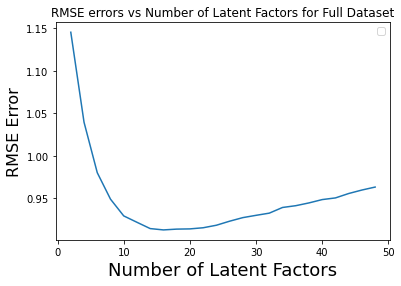

In [129]:

plot_error_vs_latent_factors(sweep_k,result_nmf_all_rmse,"RMSE","Full Dataset")


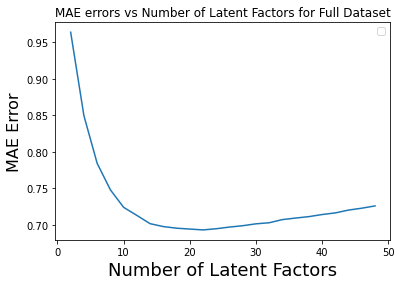

In [128]:

plot_error_vs_latent_factors(sweep_k,result_nmf_all_mae,"MAE","Full Dataset")

In [132]:
best_latent_factor_nmf_all_rmse = sweep_k[np.argmin(result_nmf_all_rmse)]
best_latent_factor_nmf_all_mae = sweep_k[np.argmin(result_nmf_all_mae)]
print("Optimal number of latent factors for NMF via RMSE Error {} and MAE error {}".format(best_latent_factor_nmf_all_rmse,best_latent_factor_nmf_all_mae))

Optimal number of latent factors for NMF via RMSE Error 16 and MAE error 22


No, the number of movie genres if 951 but the optimal latent factors are 16 or 22 here

## ROC curves

In [133]:
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [136]:
thresholds = [2.5, 3, 3.5, 4]
algo_rmse = NMF(n_factors = best_latent_factor_nmf_all_rmse)
algo_mae = NMF(n_factors = best_latent_factor_nmf_all_mae)
trainset, testset = train_test_split(data, test_size=0.1,shuffle=True)
algo_rmse.fit(trainset)
algo_mae.fit(trainset)
predictions_rmse = algo.test(testset)
predictions_mae = algo.test(testset)

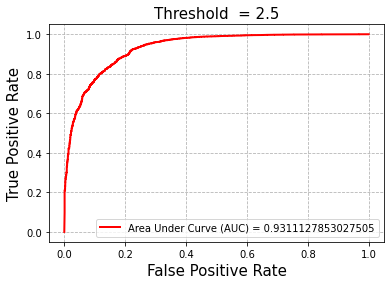

Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=3.320314


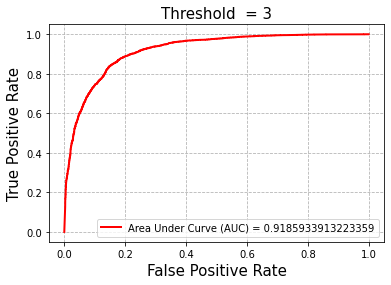

Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=3.770078


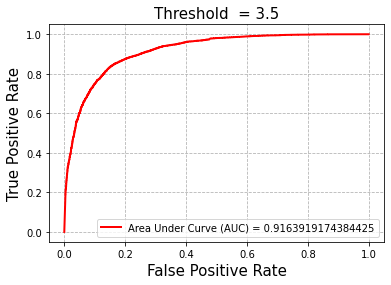

Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=4.024691


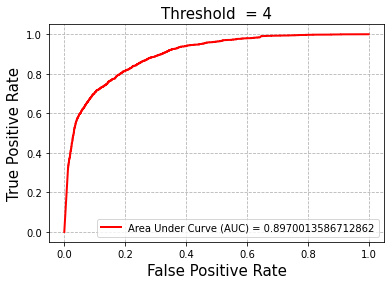

Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=4.345731


In [137]:
get_roc_params(predictions_rmse ,thresholds)

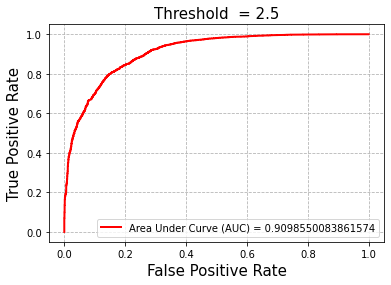

Best Threshold=3.244124


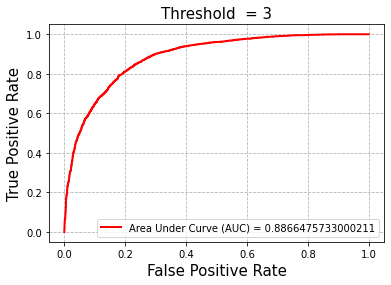

Best Threshold=3.410522


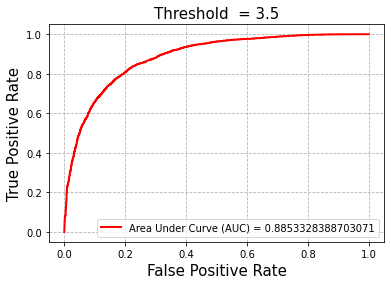

Best Threshold=3.559608


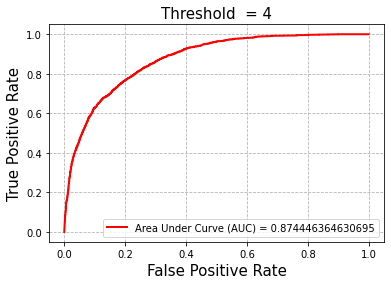

Best Threshold=3.834010


In [127]:
get_roc_params(predictions_mae ,thresholds)

In [11]:
def get_roc_params(predictions ,thresholds):
    true_ratings = [getattr(pred, 'r_ui') for pred in predictions]
    estimated_rating = [getattr(pred, 'est') for pred in predictions]
    fpr = {}
    tpr = {}
    threshs = {}
    for i, thresh in enumerate(thresholds):
        true_ratings_bins = [1 if r > thresh else 0 for r in true_ratings]
        threshs[i] = thresh
        fpr[i], tpr[i], thresholdi = metrics.roc_curve(true_ratings_bins, estimated_rating)
        plot_roc(fpr[i], tpr[i], thresh)

        T_func = (1-fpr[i]) + tpr[i]
        ix = np.argmax(T_func)
        best_thresh = thresholdi[ix]
        print('Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=%f' % (best_thresh))
    

def plot_roc(fpr, tpr, thresh, file_name=None):
    fig, ax = plt.subplots()
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, color = 'r', label='Area Under Curve (AUC) = {}'.format(roc_auc))
    ax.grid(color='0.7', linestyle='--', linewidth=0.8)

    ax.set_xlabel('False Positive Rate', size=15)
    ax.set_ylabel('True Positive Rate', size=15)
    ax.legend(loc="lower right")
    plt.title('Threshold  = {}'.format(thresh), size=15)
    plt.show()
     

## Trimmed Test Sets

In [12]:
min_movie_ratings = 2 #a movie has was rated at least 
min_user_ratings =  5 # has atleast these many ratings
min_var = 2

popular_df = ratings_df.groupby("movieId").filter(lambda x: x['rating'].count() > min_movie_ratings)
unpopular_df =  ratings_df.groupby("movieId").filter(lambda x: x['rating'].count() <= min_movie_ratings)
high_variance_df =  ratings_df.groupby("movieId").filter(lambda x: x['rating'].var() > min_var and x['rating'].count() > min_user_ratings)


In [13]:
kf = KFold(n_splits=10)
rmse_populars = []

for k in sweep_k:
    algo = NMF(n_factors = k)
    accu = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        popu_test_trim = [x for x in testset if x[1] in popular_df.movieId.values]
        predictions = algo.test(popu_test_trim)
        accu.append(accuracy.rmse(predictions, verbose=True))
    accu_mean = np.mean(accu)
    rmse_populars.append(accu_mean)
    
pickle.dump( rmse_populars, open( "result_nmf_popu_rmse.pkl", "wb" ) )

RMSE: 1.1521
RMSE: 1.1327
RMSE: 1.1329
RMSE: 1.1356
RMSE: 1.1417
RMSE: 1.1363
RMSE: 1.1502
RMSE: 1.1415
RMSE: 1.1271
RMSE: 1.1523
RMSE: 1.0209
RMSE: 1.0315
RMSE: 1.0325
RMSE: 1.0301
RMSE: 1.0246
RMSE: 1.0358
RMSE: 1.0264
RMSE: 1.0361
RMSE: 1.0173
RMSE: 1.0067
RMSE: 0.9667
RMSE: 0.9624
RMSE: 0.9633
RMSE: 0.9710
RMSE: 0.9729
RMSE: 0.9710
RMSE: 0.9662
RMSE: 0.9681
RMSE: 0.9470
RMSE: 0.9534
RMSE: 0.9235
RMSE: 0.9374
RMSE: 0.9361
RMSE: 0.9217
RMSE: 0.9353
RMSE: 0.9374
RMSE: 0.9232
RMSE: 0.9395
RMSE: 0.9368
RMSE: 0.9216
RMSE: 0.8894
RMSE: 0.9031
RMSE: 0.9128
RMSE: 0.9214
RMSE: 0.9066
RMSE: 0.9158
RMSE: 0.9072
RMSE: 0.9128
RMSE: 0.9119
RMSE: 0.9225
RMSE: 0.8970
RMSE: 0.8984
RMSE: 0.8881
RMSE: 0.8979
RMSE: 0.9039
RMSE: 0.9085
RMSE: 0.8973
RMSE: 0.9046
RMSE: 0.9040
RMSE: 0.8977
RMSE: 0.8983
RMSE: 0.8992
RMSE: 0.8972
RMSE: 0.9043
RMSE: 0.8946
RMSE: 0.8837
RMSE: 0.8891
RMSE: 0.9079
RMSE: 0.9072
RMSE: 0.8918
RMSE: 0.8910
RMSE: 0.9001
RMSE: 0.8974
RMSE: 0.8907
RMSE: 0.9022
RMSE: 0.8970
RMSE: 0.8924

In [124]:
def plot_error_vs_latent_factors(sweep_k,errors,error_type,title):
    plt.legend(error_type+ " errors vs Number of Latent Factors for " +title)
    plt.xlabel("Number of Latent Factors", fontsize=18)
    plt.ylabel("{} Error".format(error_type), fontsize=16)
    plt.title(error_type+ " errors vs Number of Latent Factors for " +title)
    plt.plot(sweep_k, np.array(errors))

In [16]:
with open('result_nmf_popu_rmse.pkl', 'rb') as f:
    result_nmf_popu_rmse = pickle.load(f)

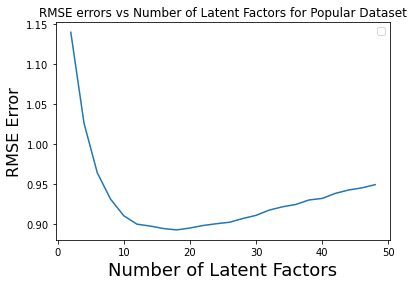

In [125]:
plot_error_vs_latent_factors(sweep_k,result_nmf_popu_rmse,"RMSE","Popular Dataset")

In [18]:
kf = KFold(n_splits=10)
rmse_unpopulars = []

for k in sweep_k:
    algo = NMF(n_factors = k)
    accu = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        unpopu_test_trim = [x for x in testset if x[1] in unpopular_df.movieId.values]
        predictions = algo.test(unpopu_test_trim)
        accu.append(accuracy.rmse(predictions, verbose=True))
    accu_mean = np.mean(accu)
    rmse_unpopulars.append(accu_mean)
    
pickle.dump( rmse_unpopulars, open( "result_nmf_unpopu_rmse.pkl", "wb" ) )

RMSE: 1.1897
RMSE: 1.2881
RMSE: 1.2513
RMSE: 1.2625
RMSE: 1.2197
RMSE: 1.2040
RMSE: 1.2478
RMSE: 1.1579
RMSE: 1.2094
RMSE: 1.2546
RMSE: 1.1991
RMSE: 1.1808
RMSE: 1.2522
RMSE: 1.2128
RMSE: 1.1898
RMSE: 1.1998
RMSE: 1.1850
RMSE: 1.2236
RMSE: 1.2615
RMSE: 1.1743
RMSE: 1.2125
RMSE: 1.2428
RMSE: 1.1349
RMSE: 1.1623
RMSE: 1.1306
RMSE: 1.1513
RMSE: 1.2576
RMSE: 1.2575
RMSE: 1.2307
RMSE: 1.2436
RMSE: 1.1542
RMSE: 1.1983
RMSE: 1.2417
RMSE: 1.1228
RMSE: 1.2738
RMSE: 1.1779
RMSE: 1.1922
RMSE: 1.2003
RMSE: 1.2775
RMSE: 1.1748
RMSE: 1.1872
RMSE: 1.2218
RMSE: 1.2085
RMSE: 1.1934
RMSE: 1.2087
RMSE: 1.1196
RMSE: 1.2146
RMSE: 1.2085
RMSE: 1.2104
RMSE: 1.1779
RMSE: 1.1409
RMSE: 1.2107
RMSE: 1.1490
RMSE: 1.1838
RMSE: 1.2501
RMSE: 1.1587
RMSE: 1.2274
RMSE: 1.1888
RMSE: 1.1509
RMSE: 1.2002
RMSE: 1.1872
RMSE: 1.1671
RMSE: 1.2339
RMSE: 1.1515
RMSE: 1.1860
RMSE: 1.2291
RMSE: 1.2246
RMSE: 1.1825
RMSE: 1.1849
RMSE: 1.1114
RMSE: 1.2271
RMSE: 1.1679
RMSE: 1.1505
RMSE: 1.1673
RMSE: 1.1694
RMSE: 1.1623
RMSE: 1.1437

In [19]:
with open('result_nmf_unpopu_rmse.pkl', 'rb') as f:
    result_nmf_unpopu_rmse = pickle.load(f)

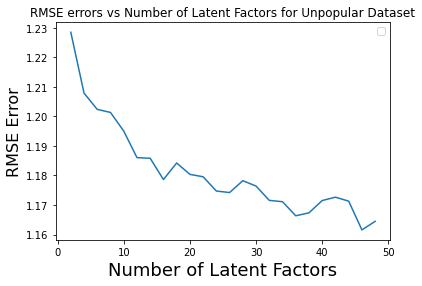

In [126]:
plot_error_vs_latent_factors(sweep_k,result_nmf_unpopu_rmse,"RMSE","Unpopular Dataset")

In [21]:
kf = KFold(n_splits=10)
rmse_highvar = []

for k in sweep_k:
    algo = NMF(n_factors = k)
    accu = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        highvar_test_trim = [x for x in testset if x[1] in high_variance_df.movieId.values]
        predictions = algo.test(highvar_test_trim)
        accu.append(accuracy.rmse(predictions, verbose=True))
    accu_mean = np.mean(accu)
    rmse_highvar.append(accu_mean)
    
pickle.dump( rmse_highvar, open( "result_nmf_highvar_rmse.pkl", "wb" ) )

RMSE: 1.4492
RMSE: 1.8120
RMSE: 1.4615
RMSE: 1.5611
RMSE: 1.6619
RMSE: 1.6417
RMSE: 1.7068
RMSE: 1.7196
RMSE: 1.3227
RMSE: 1.4825
RMSE: 1.4867
RMSE: 1.4503
RMSE: 1.4163
RMSE: 1.7322
RMSE: 1.5849
RMSE: 1.8836
RMSE: 1.8507
RMSE: 1.6703
RMSE: 1.3662
RMSE: 1.5576
RMSE: 1.3833
RMSE: 1.4556
RMSE: 1.3860
RMSE: 1.4246
RMSE: 1.5975
RMSE: 1.4642
RMSE: 1.5374
RMSE: 1.5083
RMSE: 1.5773
RMSE: 1.4495
RMSE: 1.3746
RMSE: 1.4626
RMSE: 1.7399
RMSE: 1.4470
RMSE: 1.5233
RMSE: 1.5269
RMSE: 1.5835
RMSE: 1.2993
RMSE: 1.4263
RMSE: 1.7244
RMSE: 1.3320
RMSE: 1.5321
RMSE: 1.6141
RMSE: 1.3756
RMSE: 1.5184
RMSE: 1.6579
RMSE: 1.1988
RMSE: 1.5228
RMSE: 1.5971
RMSE: 1.3495
RMSE: 1.2765
RMSE: 1.4293
RMSE: 1.5211
RMSE: 1.6452
RMSE: 1.3478
RMSE: 1.4875
RMSE: 1.5442
RMSE: 1.6771
RMSE: 1.3767
RMSE: 1.4260
RMSE: 1.9252
RMSE: 1.6325
RMSE: 1.5008
RMSE: 1.5086
RMSE: 1.6971
RMSE: 1.5378
RMSE: 1.3137
RMSE: 1.6061
RMSE: 1.4243
RMSE: 1.2575
RMSE: 1.4413
RMSE: 1.5328
RMSE: 1.6811
RMSE: 1.4673
RMSE: 1.7174
RMSE: 1.2249
RMSE: 1.0897

In [22]:
with open('result_nmf_highvar_rmse.pkl', 'rb') as f:
    result_nmf_highvar_rmse = pickle.load(f)

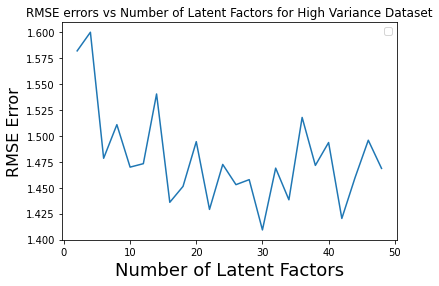

In [127]:
plot_error_vs_latent_factors(sweep_k,result_nmf_highvar_rmse,"RMSE","High Variance Dataset")

In [139]:
best_latent_factor_nmf_popu_rmse = sweep_k[np.argmin(result_nmf_popu_rmse)]
best_latent_factor_nmf_unpopu_rmse = sweep_k[np.argmin(result_nmf_unpopu_rmse)]
best_latent_factor_nmf_highvar_rmse = sweep_k[np.argmin(result_nmf_highvar_rmse)]

In [141]:
print("Optimal number of latent factors for NMF on Popular Testset {} Unpopular Test Set {} High Variance Testset {} ".format(best_latent_factor_nmf_popu_rmse,best_latent_factor_nmf_unpopu_rmse,best_latent_factor_nmf_highvar_rmse))

Optimal number of latent factors for NMF on Popular Testset 18 Unpopular Test Set 46 High Variance Testset 30 


# Q9

## Matrix factorization

In [24]:
ratings_df.columns

Index(['Unnamed: 0', 'userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [25]:
R_df = ratings_df.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
R_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
R = R_df.values
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [27]:
from sklearn.decomposition import NMF
model = NMF(n_components=20, init='random', random_state=0)
V= model.fit_transform(R)  # user latent factors features matrix
U = model.components_.T     # item latent factors (= H.T)  the coefficient matrix)

/home/anw/ucla_coursework/219/code/ECE219_data_mining_project/env219/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [90]:
item_latent_factors  = pd.DataFrame(U.T, columns = R_df.columns)

In [109]:
item_latent_factorsT = item_latent_factors.transpose()
# item_latent_factorsT['movieId'] = item_latent_factorsT.index

In [107]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [113]:
item_latent_movie_genres = item_latent_factorsT.merge(movies_df, 
                    how = 'left',
                on = 'movieId')
                # right_on = 'movieId')

In [116]:
item_latent_movie_genres.sort_values(by=[3],ascending=False)[[3,'title','genres']]

,3,title,genres
686,2.120149,Rear Window (1954),Mystery|Thriller
694,2.029901,Casablanca (1942),Drama|Romance
950,1.775025,Chinatown (1974),Crime|Film-Noir|Mystery|Thriller
690,1.732559,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller
659,1.697881,"Godfather, The (1972)",Crime|Drama
...,...,...,...
4661,0.000000,"Freshman, The (1990)",Comedy|Crime
4660,0.000000,Final Analysis (1992),Drama|Romance|Thriller
4658,0.000000,Desk Set (1957),Comedy|Romance
4656,0.000000,Dead of Night (1945),Horror|Mystery


In [118]:
item_latent_movie_genres.sort_values(by=[2],ascending=False)[[2,'title','genres']]

,2,title,genres
4791,2.306397,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
3633,2.199585,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
4131,2.154116,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
6726,2.130854,Iron Man (2008),Action|Adventure|Sci-Fi
6755,1.957504,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi
...,...,...,...
4233,0.000000,"Thrill of It All, The (1963)",Comedy
4232,0.000000,"Red Badge of Courage, The (1951)",Drama|War
4231,0.000000,"Patch of Blue, A (1965)",Drama|Romance
4230,0.000000,"Black Stallion, The (1979)",Adventure|Children|Drama


In [117]:
item_latent_movie_genres.sort_values(by=[1],ascending=False)[[1,'title','genres']]

,1,title,genres
3560,0.193332,"Man Who Wasn't There, The (2001)",Crime|Drama
2512,0.192776,American Graffiti (1973),Comedy|Drama
3953,0.191952,Igby Goes Down (2002),Comedy|Drama
83,0.191734,Beautiful Girls (1996),Comedy|Drama|Romance
2456,0.190422,Of Mice and Men (1992),Drama
...,...,...,...
4805,0.000000,Along Came Polly (2004),Comedy|Romance
4804,0.000000,Aileen: Life and Death of a Serial Killer (2003),Documentary
4802,0.000000,Japanese Story (2003),Drama
4800,0.000000,Peter Pan (2003),Action|Adventure|Children|Fantasy


In [ ]:
adf = movies_df[item_latent_factors.columns ~movies_df['movieId'].isin()]#.merge(pd.DataFrame(sorted_user_predictions).reset_index(), 
                   # how = 'left',
                # left_on = 'movieId',
                # right_on = 'movieId')#.sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1]
                        # )

In [38]:
R_pred = np.dot(U,V.T)
R_pred = R_pred.T

In [101]:
print('Item features - U:', U.shape)
print('User features - V:', V.shape)
print(R_df.shape)
print(R_pred.shape)

Item features - U: (9724, 20)
User features - V: (610, 20)
(610, 9724)
(610, 9724)


In [41]:
preds_df = pd.DataFrame(R_pred, columns = R_df.columns)

In [147]:
R_df['> zero'] = R_df[R_df.columns].gt(0).sum(axis=1)
R_df['== zero'] = R_df[R_df.columns].eq(0).sum(axis=1)

In [149]:
sweep_t = list(range(1,26))

In [152]:
R_df.iloc[567]

movieId
1             0.0
2             0.0
3             0.0
4             0.0
5             0.0
            ...  
193585        0.0
193587        0.0
193609        0.0
> zero       23.0
== zero    9701.0
Name: 568, Length: 9726, dtype: float64

In [50]:
userID = 67
num_recommendations=10
user_full, recommendations = recommend_movies(preds_df, userID, movies_df, ratings_df, num_recommendations)

User 67 has already rated 36 movies.
Recommending the highest 10 predicted ratings movies not already rated.


In [51]:
recommendations

,movieId,title,genres
6679,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
505,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
654,858,"Godfather, The (1972)",Crime|Drama
457,527,Schindler's List (1993),Drama|War
3123,4226,Memento (2000),Mystery|Thriller
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
2657,3578,Gladiator (2000),Action|Adventure|Drama
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
892,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi


In [42]:
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    
    user_row_number = userID - 1
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False)
    user_data = ratings_df[ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                        sort_values(['rating'], ascending=False))
    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending the highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])].
            merge(pd.DataFrame(sorted_user_predictions).reset_index(), 
                    how = 'left',
                left_on = 'movieId',
                right_on = 'movieId').
            rename(columns = {user_row_number: 'Predictions'}).
            sort_values('Predictions', ascending = False).
                        iloc[:num_recommendations, :-1]
                        )

    return user_full, recommendations